# Introduction to PyTorch

Hello everyone to the deep learning course.

This introduction notebook should give you a start to work with PyTorch, one of the standard deep learning frameworks.



---

## Import necessary libraries

Run the cell below to import all necessary libraries.

If you get an error that something is missing please install

- **Matplotlib** via `pip install matplotlib`
- **Numpy** via `pip install numpy`
- **PyTorch** according to the installation guide on [their website](https://pytorch.org/). Note that there is a difference between CPU/GPU (cuda) installation.

In [1]:
# for plotting
import matplotlib.pyplot as plt

# numpy is the standard numerical library for Python
import numpy as np

# torch is the deep learning library we are using in this course
import torch

---

## Check CUDA support (not necessary for this course)

Let's test now whether you installed PyTorch with GPU support (won't be the case if you run it on a machine without NVIDIA GPU).

In [2]:
try:
    x = torch.zeros().cuda()
    print("gpu support works")
except:
    print("no gpu found or pytorch has been installed without cuda support")

no gpu found or pytorch has been installed without cuda support


---

## Numerical computations with tensors

PyTorch behaves very similar to numpy. You can define tensors (= high dimensional matrices) which you can then use in numerical computations.

#### Simple Arithmetics

In [3]:
x = torch.tensor([1.])      # define two tensors x and y
y = torch.tensor([2.])
z = x + y                   # z is the sum of both
print(f"z is {z}")          # this will print the tensor itself (you will read something like tensor([3.]))
print(f"z is {z.item()}")   # this will print the value stored within the tensor

z is tensor([3.])
z is 3.0


#### Linear Algebra

In [4]:
M = torch.tensor([                # we can also define matrix types
    [1., 1.],
    [-1., 1.]
])
v = torch.tensor([3., 1.])        # and vectors
u = M @ v                         # and compute u via applying M on v
print(f"u is {u}")                # show the value of u
# print(f"u is {u.item()}")       # this will fail now as u is no scalar type anymore

u is tensor([ 4., -2.])


#### Higher-Order Tensors

In [5]:
L = torch.tensor([               # higher-order tensors are possible as well
    [
        [1., 1.],
        [1., 1.]
    ],
    [
        [1., 1.],
        [1., 1.]
    ],
    [
        [1., 1.],
        [1., 1.]
    ],
])
print(f"L has shape {L.shape}")  # we can print its shape to see what dimensionality it has

u = torch.matmul(L, v)           # matrix vector computation still works 
print(f"u has shape {u.shape}")

K = torch.einsum("a b c, b c -> a", L, M)   # we can even do complicated tensor contractions
print(f"K has shape {K.shape}")

L has shape torch.Size([3, 2, 2])
u has shape torch.Size([3, 2])
K has shape torch.Size([3])


#### Point-Wise Operations

In [6]:
x = torch.tensor([1., 2., 3., 4.])

y = x.square()                         # beyond vector-matrix-tensor reductions we also have a range of pointwise functions
                                       # those are applied to tensor elements individually
print(f"y is {y}")

y is tensor([ 1.,  4.,  9., 16.])


There are many many functions that you can use with tensors. We recommend to have a look at PyTorch's [excellent API documentation](https://pytorch.org/docs/stable/index.html).

#### Broadcasting

In [7]:
x = torch.tensor([[1., 2., 3., 4]])
print(f"x has shape {x.shape}")

y = torch.tensor([[1.], [2.], [3.], [4.]])
print(f"y has shape {y.shape}")

z = x + y                             # broadcasting allows us to simplify arithmetic operations / tensor reductions 
                                      # for tensors with different shapes, if the axes match. here all elements of x
                                      # and all elements of y are summed pointwise and their result is stored within a
                                      # 4x4 tensor
print(f"z has shape {z.shape}")

x has shape torch.Size([1, 4])
y has shape torch.Size([4, 1])
z has shape torch.Size([4, 4])


#### Running computations on the GPU to speed up highly-parallel computations

In [8]:
dim = 500
A = torch.randn(dim, dim)          # create two very big tensors
B = torch.randn(dim, dim, dim)

In [9]:
%%timeit
C = torch.einsum("a b, a b c -> c", A, B)  # do some expensive tensor contraction on them

82 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
if torch.cuda.is_available():
    A = A.cuda()                                # send all tensors to the GPU
    B = B.cuda()
else:
    print("This won't work if you did not install PyTorch with CUDA support")

This won't work if you did not install PyTorch with CUDA support


In [11]:
%%timeit
if torch.cuda.is_available():
    C = torch.einsum("a b, a b c -> c", A, B)   # this should be much faster now

1.06 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


---

## Automatic Differentiation

Besides trivialized GPU support for numeric computation the more important reason to use PyTorch for Machine Learning is the support of [**Automatic Differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation).

Assume we want to compute the derivative of a Python function 

In [12]:
def f(x):
    return x ** 2

Then we have three options:

**Option 1:** We compute the derivative `f'` by hand and code it ourselves

- **Pros**: 
    - We can optimize the implementation by hand.
    - It is fast and exact.
- **Cons**: 
    - We have to do this for every function by hand. 
    - This becomes nasty for complicated expressions.
    - It becomes impossible for dynamically generated code (e.g. if `f` contains a for loop).

In [13]:
def f_prime(x):
    return 2 * x

**Option 2:** We approximate the derivative `f'` via [finite differences](https://en.wikipedia.org/wiki/Finite_difference)

- **Pros**: This is a very generic implementation that works for every function
- **Cons**: 
    - Becomes slow in high dimensions.
    - We have to choose some epsilon.
    - It is **not exact**!

In [14]:
def finite_difference_derivative(f, x, epsilon=1e-2):
    return ( f(x + epsilon) - f(x - epsilon) ) / (2 * epsilon)

x = torch.tensor(3.)
d1 = f_prime(x)
d2 = finite_difference_derivative(f, x)

print(f"d1 is {d1.item()}, d2 is {d2.item()}")

d1 is 6.0, d2 is 5.999994277954102


**Option 3 (preferred):** We compute the derivative of `f` via [**Automatic Differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation). Here we implement `f'` for each primitive function (addition, sine, matrix multiplication, ...) and compute the derivative of complex nested functions made of those primitives using the [chain-rule](https://en.wikipedia.org/wiki/Chain_rule).

- **Pros**: Get derivatives for complex nested functions for free with one algorithm. It's fast and **it's exact**!
- **Cons**: 
    - Implement derivatives for each primitive (however the existing library contains most imaginable).
    - A buch of details are necessary to make this method efficient (those are hidden under the hood of PyTorch and you barely have to care about them in most cases).
   
PyTorch implements [**Reverse-Mode Automatic Differentation**](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation). If you are curious about the details, have a look [here](https://pytorch.org/docs/stable/notes/autograd.html).

The most important take-away is, that you can compute *Vector-Jacobian products* efficiently, namely expressions of the form $v^T \frac{d f}{d x}$ where $v$ is some vector and $f$ is some Python function.

Let's look at the example to see how that works

In [15]:
x = torch.tensor(3.).requires_grad_(True)    # this tells PyTorch that x should now be considered for derivatives during automatic differentation
y = f(x)                                     # now we just compute the result of f as we are used to it in standard Python

print(f"y is {y.item()}")

v = torch.tensor(1.)                         # we define the v as introduce above - in the languate of Autograd this is called the `output derivative`

d3, = torch.autograd.grad(                   # this is where the magic happens. torch.autograd.grad computes v^T df/dx for us. 
    outputs=y,                               # We feed in the output of the computation y = f(x)
    inputs=x,                                # The input wrt we want to take derivatives (d/dx)
    grad_outputs=v                           # And the output derivative. If we set it to 1 we should get the usual derivative.
)                                            # Important remark: for conventional reasons the result of torch.autograd.grad is a tuple.
                                             # So we unpack it to get the actual derivative.

print(f"d3 is {d3.item()}")

y is 9.0
d3 is 6.0


---

## Parameters and optimization

The reason why are interested in derivatives is that a lot in machine learning deals with optimizing functions wrt parameters. You will learn the theory about it in the lecture.

Let's assume we are given a somewhat complicated function

In [16]:
def f(x):
    return  (x * np.pi).cos() * x

We can have a look at it by plotting it with matplotlib

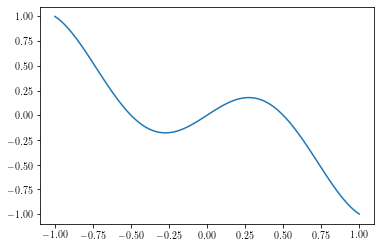

In [17]:
x = torch.linspace(-1, 1, 100)
y = f(x)
plt.plot(x, y)

Our aim is now to approximate this function using a set of polynomials: $f(x) \approx \sum\limits_{i=0}^{N} a_{i} \cdot x^{i}$.

For maximum degree $N$ the coefficients $\{ a_i | i=0\ldots N\} $ are free parameters that we have to tune.

While there exist much more principled approaches to polynomial regression, we choose to find the optimal $a_i$ using [**Gradient Descent**](https://en.wikipedia.org/wiki/Gradient_descent).

Gradient descent allows us to find $\theta^{*}$ which minimizes a loss function $\ell(\theta)$. It works as a local and step-wise procedure:

1. Start with an initial guess for $\theta$. Call it $\theta^{(0)}$.
2. Evaluate $\ell(\theta^{(i)}$.
3. Compute $\frac{d \ell(\theta^{(i)}}{d \theta}$.
4. Update $\theta^{(i+1)} = \theta^{(i)} - \alpha \cdot \frac{d \ell(\theta^{(i)}}{d \theta}$. Here $\alpha$ is the *learning rate* which is a small number.
5. If not converged, set $i = i +1$ and continue with 2.
6. Set $\theta^{*} = \theta^{(i)}$

Enough theory, let's implement it in PyTorch!

As a first function we implement the polynomials themselves:

In [18]:
def evaluate_polynomial(coeffs, x):
    N = coeffs.shape[0]
    y_accum = torch.zeros_like(y)         # this makes y_accum a zero initialized tensor with the same shape as x
    x_accum = torch.ones_like(x)          # this makes x_accum a one initialized tensor with the same shape as x
    for i in range(N):
        y_accum = y_accum + coeffs[i] * x_accum
        x_accum = x_accum * x
    return y_accum

Now lets plot some polynomials to see how they look like. We just use randomly initalized coefficients:

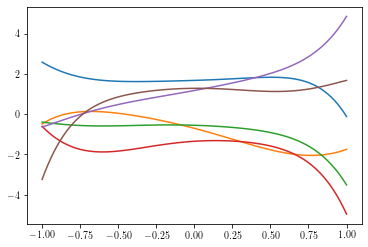

In [19]:
N = 6

for i in range(6):                       
    coeffs = torch.randn(N+1)
    x = torch.linspace(-1, 1, 100)
    y = evaluate_polynomial(coeffs, x)
    plt.plot(x, y)

For our optimization procedure we need to define a loss function which compares our current fit against the target function.

Here we choose a simple mean-squared error that is evaluated point-wise.

In [20]:
def loss_function(y_true, y_pred):
    return (y_true - y_pred).square().mean()     

Let's define our parameters. PyTorch offers a class `torch.nn.Parameter` that eats a tensor and marks it as a parameter that can be optimized over plus some other convenience options.
E.g. parameters can be used for taking gradients by default - you don't need to call `.requires_grad_(True)` on them.

In [21]:
coeffs = torch.nn.Parameter(               
    torch.randn(N+1) / N
)
print(f"coeffs are {coeffs}")

coeffs are Parameter containing:
tensor([ 0.3170,  0.4083,  0.2519, -0.0300,  0.0645,  0.1830, -0.1209],
       requires_grad=True)


Let look at our initial fit

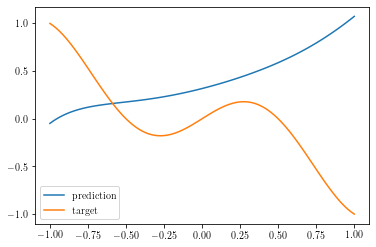

In [22]:
x = torch.linspace(-1, 1, 100)
y_pred = evaluate_polynomial(coeffs, x).detach()
y_true = f(x) 
plt.plot(x, y_pred, label="prediction")
plt.plot(x, y_true, label="target")
plt.legend()

We use PyTorch's implemented gradient descent optimizer:

In [23]:
learning_rate = 1e-4
optim = torch.optim.SGD(params=[coeffs], lr=learning_rate)

Let's start the optimization.

We will just randomly sample some points in $[-1, 1]$, evaluate the target function and the polynomial for them, compute the mean-square error, compute it's derivative and them run one step of gradient-descent.

Luckily, PyTorch offers a lot to make life easy:

In [24]:
n_samples = 100                                  # number of samples we use in each iteration
n_iterations = 50_000                            # number of gradient descent iterations

for it in range(n_iterations):
    optim.zero_grad()                            # makes sure that the automatic differentiation buffer is clean - this step is important!
    x = torch.rand(n_samples) * 2 - 1            # sample 100 points in [-1, 1]
    y_pred = evaluate_polynomial(coeffs, x)      # compute our current estimate of the polynomial
    y_true = f(x)                                # compute the actual values for the same xs
    loss = loss_function(y_true, y_pred)         # compute the mean-squared error loss
    
    loss.backward()                              # This is a magic function of PyTorch. It will compute the gradients of `loss` with respect to all `torch.nn.Parameters` that appear in the computation.
                                                 # Theoretically, we could have used something like coeffs_grad, = torch.autograd.grad(loss, coeffs) and computed the gradient descent step explicitly.
                                                 # However, as this becomes very tedious once your model contains many parameter tensors (e.g. deep neural networks) and your optimizers become more sophisticated.
                                                 
    optim.step()                                 # run one step of gradient descent
    
    print(f"iteration {it}, mean-squared error is {loss.item():.4}", end="\r")  # print current loss 

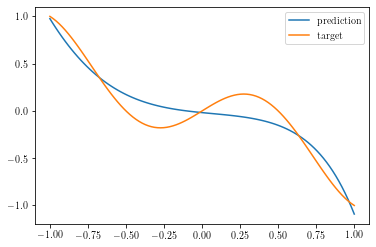

In [25]:
x = torch.linspace(-1, 1, 100)
y_pred = evaluate_polynomial(coeffs, x).detach()
y_true = f(x) 
plt.plot(x, y_pred, label="prediction")
plt.plot(x, y_true, label="target")
plt.legend()

The fit is not very great. There is a good reason, why better methods for polynomial regression exist.

---

## Modules and composability

Using simple variables and Python functions becomes messy very quickly. For this reason PyTorch allows us to compose functions with parameters into `Modules` which can be composed and reused without any pain.

As an illustration of how that works, we will try to fit the same function as before, but now using a slightly different model. 

Here we choose a kernel-regression given by $f(x) \approx \sum\limits_{i=0}^{N} a_{i} \phi_{i}(x)$. Where the $\phi_i$ are different *kernel-functions*.

Our polynomials from before are a possible choice of kernel functions. However, now we choose radial basis functions of the form $\phi_i(x) = \exp(-\sigma_{i} \cdot (x - \mu_{i})^2)$. In addition to our coefficients $a_i$ we now have parameters $\sigma_i$ and $\mu_i$ to fit.

As before we try to do that via gradient descent, however now we are using [**PyTorch Modules**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to structure our code.

In [26]:
class RbfBasis(torch.nn.Module):
    
    def __init__(self, mu_init, log_sigma_init):
        super().__init__()                                       # this line should always be the first in the module constructor
        self.mu = torch.nn.Parameter(mu_init)                    # we bind parameters to the module by simple member assignment
        self.log_sigma = torch.nn.Parameter(log_sigma_init)

    def forward(self, x):                # Each module has a `forward` method. It implements the logic of what happens when you apply the module like a function, e.g. like module(x)
                                         # It helps to think of modules as functions with an internal state (parameters). The `forward` method implements what is returned after calling the function.
        
        x = x.unsqueeze(-1)              # reshape x into  shape [n_samples, 1]
        mu = self.mu.unsqueeze(0)        # reshape mu into shape [1, N]
        diff = x - mu                    # then we can compute x - mu via broadcasting. This will have shape [n_samples, N].
        
        sigma = self.log_sigma.exp()     # to avoid negative sigmas we parameterize their log-values instead
        
        return torch.exp(-sigma * diff.square())   # returns the [n_samples, N] tensor containing the kernel basis
    
    
class KernelRegression(torch.nn.Module):
    
    def __init__(self, basis, coeffs_init):
        super().__init__()
        self.basis = basis
        self.coeffs = torch.nn.Parameter(coeffs_init)
    
    def forward(self, x):
        basis_functions = self.basis(x)        # compute basis functions
        return basis_functions @ self.coeffs   # apply coefficients and sum up

Let's plot some randomly initialized models

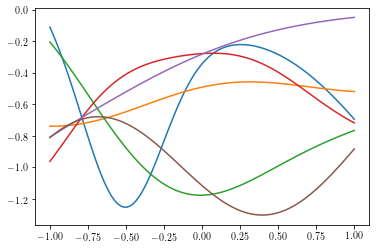

In [27]:
N = 6

for i in range(6):                       


    rbf_basis = RbfBasis(
        mu_init=torch.randn(N) * 2 - 1,
        log_sigma_init=torch.randn(N)
    )
    model = KernelRegression(
        basis=rbf_basis,
        coeffs_init=torch.randn(N) 
    )
    
    x = torch.linspace(-1, 1, 100)
    y = model(x).detach()
    plt.plot(x, y)

In [28]:
N= 6

rbf_basis = RbfBasis(
    mu_init=torch.randn(N) * 2 - 1,
    log_sigma_init=torch.randn(N)
)
model = KernelRegression(
    basis=rbf_basis,
    coeffs_init=torch.randn(N) 
)

Show the initial fit

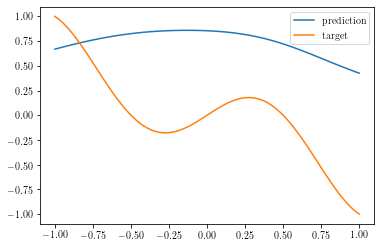

In [29]:
x = torch.linspace(-1, 1, 100)
y_pred = model(x).detach()
y_true = f(x) 
plt.plot(x, y_pred, label="prediction")
plt.plot(x, y_true, label="target")
plt.legend()

We now use another optimizer called `Adam`. You will learn more about it in the lecture.

In [30]:
learning_rate = 1e-3
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

And again run the optimization loop as before

In [31]:
n_samples = 100
n_iterations = 50_000

for it in range(n_iterations):
    optim.zero_grad()                            
    x = torch.rand(n_samples) * 2 - 1            
    y_pred = model(x)      
    y_true = f(x)                                
    loss = loss_function(y_true, y_pred)         
    loss.backward()                                                                          
    optim.step()                                 
    print(f"iteration {it}, mean-squared error is {loss.item():.4}", end="\r")  

Show the final fit

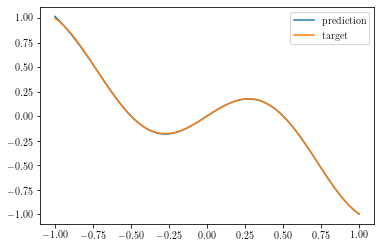

In [32]:
x = torch.linspace(-1, 1, 100)
y_pred = model(x).detach()
y_true = f(x) 
plt.plot(x, y_pred, label="prediction")
plt.plot(x, y_true, label="target")
plt.legend()

Plot our learned basis functions

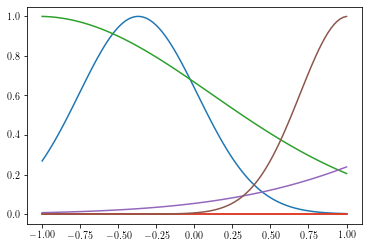

In [33]:
x = torch.linspace(-1, 1, 100)
basis = model.basis(x)

for y in basis.T:
    plt.plot(x, y.detach())

**Optional:** if CUDA works for your PyTorch setup, you can try the following:

In [34]:
try:
    model.cuda()    # send your module and thus all its internally stored parameters and buffer to the GPU
    x = torch.randn(100000, device="cuda")
    y = model(x)
except:
    print("pytorch seems to be installed without cuda")

pytorch seems to be installed without cuda


---

## Self-Exercise

To practice you can now try the following extensions of the code:

**Exercise 1:** Implement the Polynomial basis from the section *Parameters and optimization* as a `torch.nn.Module`, such that you can use it in the constructor of `KernelRegression` instead of the `rbf_basis`.

In [35]:
class PolynomialBasis(torch.nn.Module):
    
    def __init__(self, ...):
        super().__init__()
        # your code here
    
    def forward(self, ...):
        # your code here

SyntaxError: invalid syntax (<ipython-input-35-e092efa7f49b>, line 3)

**Exercise 2:** Try to extend the code, such that your regressions fits the following function $g \colon \mathbb{R}^2 \rightarrow \mathbb{R}^2$ in the interval $[0, 1] \times [0, 1]$

In [ ]:
def g(x):
    # assume x to be of shape [n_samples, 2]
    assert x.shape[1] == 2, "input should be of shape [n_samples, 2]"
    x = x * np.pi
    y = torch.cat([
        x[:, 0].cos() * x[:, 1].sin(),
        x[:, 0].sin() * x[:, 1].cos()
    ])